In [16]:
import sys 
sys.path.append('../')
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.distributions as tdist
from models import *
from loss_functions import *

MODEL_PATH = '../trained_models'
FIG_PATH = '../figs'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# read in trained models 

vae2_model = torch.load(f'{MODEL_PATH}/vae2_100.pt')
vae20_model = torch.load(f'{MODEL_PATH}/vae20_100.pt')
cbvae_mean_model = torch.load(f'{MODEL_PATH}/cbvae_mean_100.pt')
cbvae_lambda_model = torch.load(f'{MODEL_PATH}/cbvae_lambda_100.pt')
betavae_model = torch.load(f'{MODEL_PATH}/betavae_100.pt')

In [18]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=False)

with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = data.to(device)
        recon_vae2, _, _ = vae2_model(data)
        recon_vae20, _, _ = vae20_model(data)
        recon_cbvae_mean, _, _ = cbvae_mean_model(data)
        recon_cbvae_lambda, _, _ = cbvae_lambda_model(data)
        alphas, betas, _, _ = betavae_model(data)
        recon_betavae = alphas / (alphas + betas)
        break

n = 16

recon_vae2 = recon_vae2.view(128, 1, 28, 28)
recon_vae20 = recon_vae20.view(128, 1, 28, 28)
recon_cbvae_mean = recon_cbvae_mean.view(128, 1, 28, 28)
recon_cbvae_lambda = recon_cbvae_lambda.view(128, 1, 28, 28)
recon_betavae = recon_betavae.view(128, 1, 28, 28)

comparison = torch.cat([data[:n], recon_vae2[:n], recon_vae20[:n], recon_cbvae_mean[:n], recon_cbvae_lambda[:n], recon_betavae[:n]])

save_image(comparison.cpu(),
                           f'{FIG_PATH}/reconstruction_comparison.png', nrow=n)

# plt.figure(figsize=(10, 4))
# for i in range(1, 3*n+1):
#     ax = plt.subplot(4,n,i)
#     plt.imshow(comparison.cpu().detach().numpy()[i-1, 0,:,:], cmap="gray")
#     plt.axis('off')

# plt.savefig('figs/reconstruction_comparison_b_cb.png')
# plt.close()

In [19]:
repetitions = 16

# generate normal distribution 20 dim samples
random_samples2 = tdist.Normal(0, 1).sample((repetitions, 2)).to(device)
random_samples20 = tdist.Normal(0, 1).sample((repetitions, 20)).to(device)


 
vae2_recon = vae2_model.decode(random_samples2).view(repetitions, 1, 28, 28)
vae20_recon = vae20_model.decode(random_samples20).view(repetitions, 1, 28, 28)
cbvae_mean_recon = cbvae_mean_model.decode(random_samples20).view(repetitions, 1, 28, 28)
cbvae_lambda_recon = cbvae_lambda_model.decode(random_samples20).view(repetitions, 1, 28, 28)
betavae_alphas, betavae_betas = betavae_model.decode(random_samples20)
betavae_recon = betavae_alphas / (betavae_alphas + betavae_betas)
betavae_recon = betavae_recon.view(repetitions, 1, 28, 28)



comparison = torch.cat([vae2_recon[:n], vae20_recon[:n], cbvae_mean_recon[:n], cbvae_lambda_recon[:n], betavae_recon[:n]])

save_image(comparison.cpu(),
                           f'{FIG_PATH}/sampling_comparison.png', nrow=n)

save_image(vae2_recon.view(repetitions, 1, 28, 28), f'{FIG_PATH}/vae2_recon.png')
save_image(vae20_recon.view(repetitions, 1, 28, 28), f'{FIG_PATH}/vae20_recon.png')
save_image(cbvae_mean_recon.view(repetitions, 1, 28, 28), f'{FIG_PATH}/cbvae_recon.png')
save_image(cbvae_lambda_recon.view(repetitions, 1, 28, 28), f'{FIG_PATH}/cbvae_recon.png')
save_image(betavae_recon.view(repetitions, 1, 28, 28), f'{FIG_PATH}/betavae_recon.png')


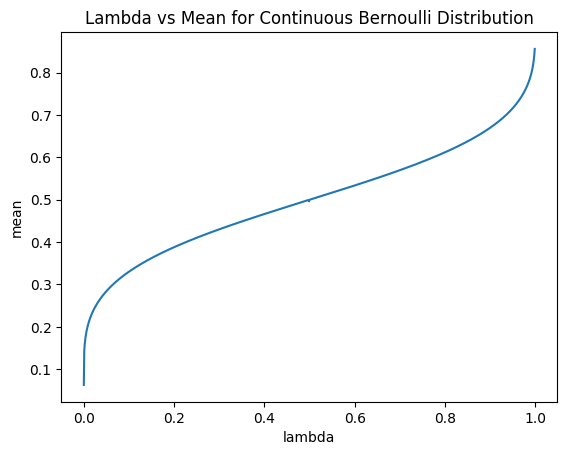

In [23]:
# plot the lambda agaist mean for continuous bernoulli distribution 

lambda_values = torch.arange(0, 1, 0.001)
mean_values = tdist.ContinuousBernoulli(probs=lambda_values).mean

plt.plot(lambda_values, mean_values)
plt.xlabel('lambda')
plt.ylabel('mean')
plt.title('Lambda vs Mean for Continuous Bernoulli Distribution')
plt.savefig(f'{FIG_PATH}/cb_mean_vs_lambda.png')